In [1]:
#Impoerting the libraries 

import nltk
nltk.download ('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Anusha.jiwani\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
# Defining the vocabulary, assigning words to the list after removing punctuation

sentence = brown.sents()
s_list =[]

for i, sent in enumerate (sentence):
    s_list.append(sent)

for i, line in enumerate (s_list):
    s_list [i].append ("/s")
    
for i, line in enumerate (s_list):
    x = ["<s>"]
    s_list[i] = x + s_list[i]

In [4]:
#Dividing Traning, Devloping and Testing dataset

trn_data = s_list[:int(0.7*len(sentence))]
dvlp_data = s_list[int(0.7*len(sentence)):int(0.8*len(sentence))]
test_data = s_list[int(0.8*len(sentence)):]

print(len(trn_data))
print(len(dvlp_data))
print(len(test_data))

40138
5734
11468


In [9]:
# Listing down the vocabulary size 

def vocabsize (data):
    size = 0
    vocab = []
    for sent in data:
        for word in sent:
            if word not in vocab:
                vocab.append(word)
                size=size+1
    return size

In [11]:
trn_data_vocabsize = vocabsize (trn_data)
dvlp_data_vocabsize = vocabsize (dvlp_data)
test_data_vocabsize = vocabsize (test_data)

In [12]:
print(trn_data_vocabsize)

49209


In [14]:
## Part A ##
#Write a code from the scratch that learns unigram and bigram models on the training data as Python dictionaries. 
# Report the perplexity of your unigram and bigram model on the both training data and test data.

import io, sys, math, re
from collections import defaultdict
import numpy as np


In [16]:
#building the n gram model
def build_ngram(data, n):
    
    total_number_words = 0
    counts = defaultdict(lambda: defaultdict(lambda: 0.0))
    
    for sentence in data:
        sentence = tuple(sentence)
        
        for i in range(len(sentence)):
            total_number_words +=1
            for k in range(n):
                if i-k < 0:
                    break
                counts[sentence[i-k:i]][sentence[i]] +=1
                
                
    proba = defaultdict(lambda: defaultdict(lambda: 0.0))
    for context in counts.keys():
        denom =0
        for w in counts[context].keys():
            denom += counts[context][w]
        for w in counts[context].keys():
            proba[context][w] = counts[context][w]/denom
    return proba

In [17]:
n = 2
print("build ngram model with n = ", n)
model_unigram = build_ngram(trn_data, n)

build ngram model with n =  2


In [19]:
def get_prob(model, context, w):
#if context in model and w in model[context]:
    return model[context][w]

In [20]:
def perplexity(model, data, n):
    perp, T = 0.0, 0
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(1, len(sentence)):
            nc = min(n-1, i)
            context = sentence[i-nc:i]
            perp += -math.log(get_prob(model, context, sentence[i]))
            T += 1
    perp = math.exp(perp/T)
    return perp

In [21]:
print("Unigram model perplexity:", perplexity(model_unigram, trn_data, n=1))

Unigram model perplexity: 1208.3057291645355


In [22]:
#for the bigram model
n = 2
print("build ngram model with n = ", n)
model_bigram = build_ngram(trn_data, n)
print("bigram model perplexity:", perplexity(model_bigram, trn_data, n=n))

build ngram model with n =  2
bigram model perplexity: 64.0904088784753


In [24]:
#(b) Implement add-λ smoothing method. With varying λ values, try to draw a similar curve to P2-(d). You should measure the perplexity on the developing data.

def build_ngram_smoothing(data, n,k):
    total_number_words = 0
    counts = defaultdict(lambda: defaultdict(lambda: 0.0))
    
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(len(sentence)):
            total_number_words +=1
            for k in range(n):
                if i-k < 0:
                    break
                counts[sentence[i-k:i]][sentence[i]] +=1
                
    proba = defaultdict(lambda: defaultdict(lambda: 0.0))
    for context in counts.keys():
        denom =0
        for w in counts[context].keys():
            denom += counts[context][w]
        for w in counts[context].keys():
            proba[context][w] = ((counts[context][w])+k)/(denom+k*trn_data_vocabsize)
    return proba , counts #(denom+k*trn_data_vocabsize)

In [25]:
def get_prob_smoothing(model, context, w,k,count_dict):
    denom = 0
    if context in model and w in model[context]:
        return model[context][w]
    elif context in model and w not in model[context]:
        value=dict(count_dict[context].items())
        denom = sum(value.values())
        return 1/(denom+trn_data_vocabsize*k)
    else:
        return 1/(trn_data_vocabsize*k)

In [27]:
def perplexity_smooth(model, data, n, k,count_dict):
    perp, T = 0.0, 0
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(1, len(sentence)):
            nc = min(n-1, i)
            context = sentence[i-nc:i]
            perp += -math.log(get_prob_smoothing(model, context, sentence[i],k,count_dict))
            T += 1
    perp = math.exp(perp/T)
    return perp

In [29]:
n = 2
print("build ngram model with n = ", n)
model_bigram_smooth , count = build_ngram_smoothing(trn_data, n,1/1000)
print("bigram model perplexity:", perplexity_smooth(model_bigram_smooth, dvlp_data, n=n,k
=1/1000, count_dict=count))

build ngram model with n =  2
bigram model perplexity: 772.8821599919268


In [30]:
def best_lambda(n,k,data):
    model_smooth , count = build_ngram_smoothing(trn_data, n , k)
    return perplexity_smooth(model_smooth, data, n=n,k=k, count_dict=count)

In [32]:
#find the best lamnda for bigram
perp=[]
k_list=[]
k=1
for i in range (50):
    k_list.append(k)
    perp.append(best_lambda(n=2,k=k,data=dvlp_data))
    k=k/10

minimum lambda 1.0000000000000003e-49
minimum perplexity 11.86377361429119


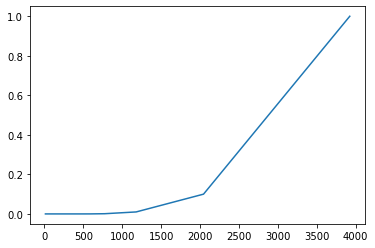

In [33]:
import matplotlib.pyplot as plt
plt.plot(perp,k_list)
print('minimum lambda',min(k_list))
print('minimum perplexity',min(perp))

minimum lambda 1.0000000000000003e-49
minimum perplexity 1130.109629009069


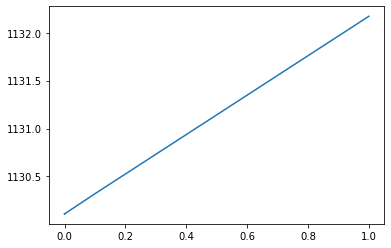

In [35]:
#for unigram
perp_uni=[]
k_list_uni=[]
k=1
for i in range (50):
    k_list_uni.append(k)
    perp_uni.append(best_lambda(n=1,k=k,data=dvlp_data))
    k=k/10
plt.plot(k_list_uni,perp_uni)
print('minimum lambda',min(k_list_uni))
print('minimum perplexity',min(perp_uni))